# Прогнозирование оттока клиентов из банка

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, plot_confusion_matrix, auc
from sklearn.utils import shuffle

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
try:
    df = pd.read_csv('/Users/anshilina/Documents/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [557]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [558]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Пропуски в данных

Единственная переменная, в которой содержатся пропуски – это `tenure`. 

In [559]:
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,9.000000
Balance,0.000000
NumOfProducts,0.000000


Tenure — сколько лет человек является клиентом банка. Заполним эти пропуски случайным значением в пределах от максимума до минимума в распределении этой переменной.

In [560]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [561]:
df.loc[df['Tenure'].isna(), 'Tenure'] = \
[randint(min(df['Tenure']), max(df['Tenure'])) for i in range(df['Tenure'].isna().sum())]

In [562]:
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,0.000000
Balance,0.000000
NumOfProducts,0.000000


### Дубликаты

Среди наблюдений нет явных дубликатов.

In [563]:
df.duplicated().sum()

0

### Распределение переменных

Изучим распределение независимых переменных.

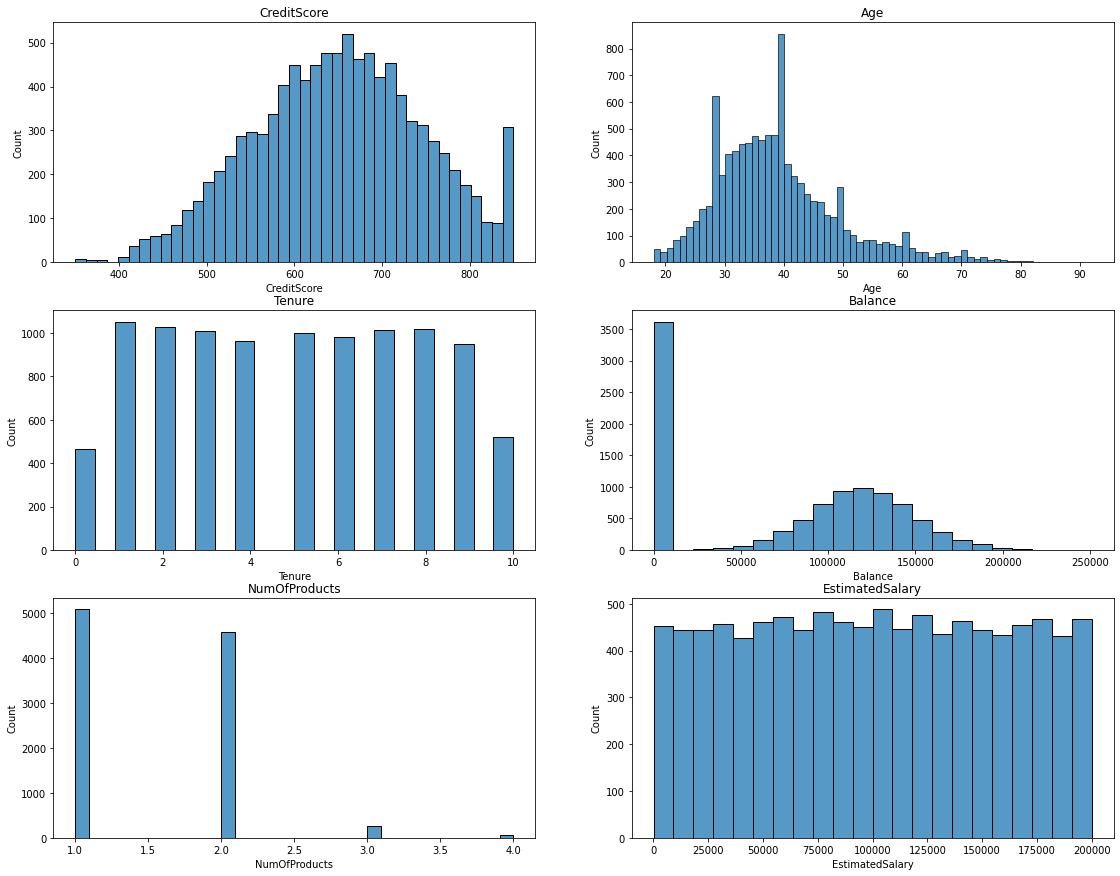

In [564]:
col_names = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
_, axs = plt.subplots(3, 2, figsize=(19,15))
axs = axs.ravel()

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[col_names[i]], data=df)
    ax.tick_params(axis='x')
    ax.set_title(col_names[i])

Видим выброс в переменной `Balance` – баланс на счете. Несмотря на то, что эти данные выделяются на общем фоне, мы не будем их удалять: вполне возможно, что часть людей не пользуются счетом, хотя он у них есть.

In [565]:
df['Balance'].value_counts()

0.00         3617
105473.74       2
130170.82       2
72594.00        1
139723.90       1
             ... 
130306.49       1
92895.56        1
132005.77       1
166287.85       1
104001.38       1
Name: Balance, Length: 6382, dtype: int64

Посмотрим на распределение категориальных переменных: медианное значение крединтного скоринга в группах жензин и мужчин из разных стран.

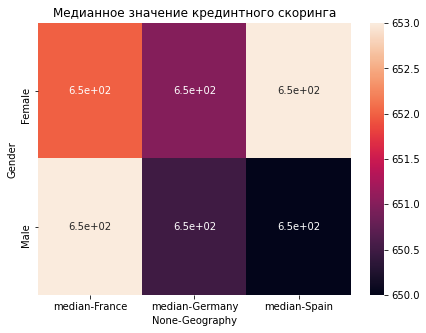

In [566]:
plt.figure(figsize=(7,5))
df_heatmap = df.pivot_table(values='CreditScore', index='Gender',columns='Geography', aggfunc={'median'})
sns.heatmap(df_heatmap,annot=True)
plt.title('Медианное значение крединтного скоринга')
plt.show()

Далее изучим, как распределяется зависимая переменная.

In [567]:
print('Уникальные значения зависимой переменной:', df['Exited'].unique())

Уникальные значения зависимой переменной: [1 0]


Мы наблюдаем дисбаланс в классах.

In [568]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

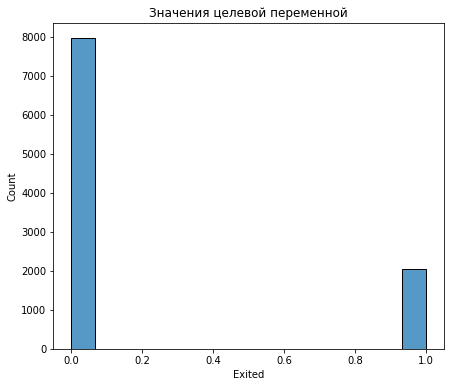

In [569]:
plt.figure(figsize=(7,6))
sns.histplot(x=df['Exited'], data=df)
plt.title('Значения целевой переменной')
plt.show()

Проверяем данные на мультиколлинеарность. Из диаграмм рассеяния видно, что признаки слабо скореллированы. Также можно увидеть тот самый "выброс" в нуле у переменной `Balance`, который мы решили оставить в выборке.

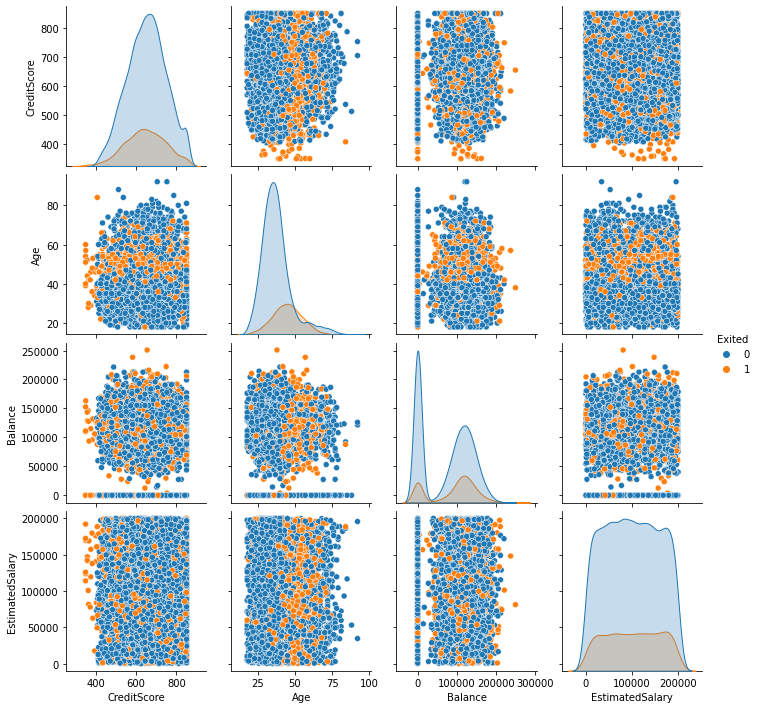

In [570]:
col_names = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']
sns.pairplot(df[col_names], hue='Exited')
plt.show()

**Вывод:** Изучив данные, мы сформулировали следующие задачи:
* Закодировать категориальные переменные (`Gender`, `Geography`)
* Получить тренировачную, валидационную и тестовую выборки
* Масштабировать количественные переменные
* Обучить модели без учета дисбаланса
* Решить проблему дисбаланса классов (выбрать наилучшую стратегию – уменьшение или увеличение классов)
* Обучить модели с учетом дисбаланса, выбрать наилучшую (сравнить метрику F1 с AUR-ROC)
* Провести финальное тестирование

Удалим признаки, которые нам не понадобятся для обучения.

In [3]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Подготовка данных

Используем прямое кодирование (OHE) для категориальных переменных. Избавляемся от первого столбца. 

In [4]:
df_ohe = pd.get_dummies(df, drop_first = True)
df_ohe.head() 

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разбираем выборку на тренировочную, валидационную и тестовую в соотношении 3:1:1.

In [5]:
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=42)

print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


## Исследование задачи

Обучим модели без учета дисбаланса классов. Для начала построим модель случайного леса, посчитаем F1 score, выведем график ROC-кривой и посчитаем площадь под ней.

In [655]:
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(features_train, target_train)

DecisionTreeClassifier(random_state=42)

In [656]:
predictions_valid = model_tree.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_tree.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.4493506493506494
AUC-ROC: 0.6606562703053931


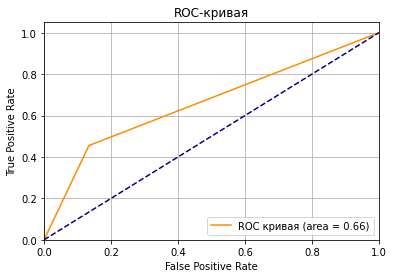

In [657]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Аналогичные шаги проделаем для модели случайного леса и логистической регрессии.

In [658]:
model_forest = RandomForestClassifier(random_state=42)
model_forest.fit(features_train, target_train)

RandomForestClassifier(random_state=42)

In [680]:
predictions_valid = model_forest.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_forest.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.5524126455906821
AUC-ROC: 0.8339514294996752


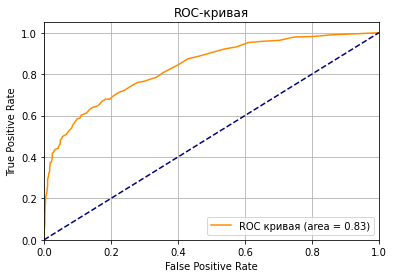

In [660]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Результаты работы логистического классификатора:

In [661]:
model_log = LogisticRegression(random_state=42)
model_log.fit(features_train_scaled, target_train)

LogisticRegression(random_state=42)

In [662]:
predictions_valid = model_log.predict(features_valid_scaled)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_log.predict_proba(features_valid_scaled)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.29615384615384616
AUC-ROC: 0.7519298245614036


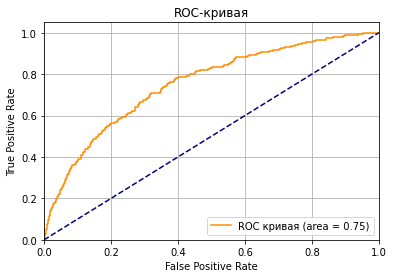

In [663]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** Самые низкие показатели качества у логичстического классификатора (F1 = 0.3, AUC-ROC=0.75). Лучше качество мы наблюдаем у модели случайного леса (F1 = 0.55, AUC-ROC=0.83). Высокий показатель F1 score и у модели дерева решений (0.45), но эта модель показывает более низкое качество при её оценке метрикой AUC-ROC (0.66). В целом результаты работы моделей неудовлетворительные. Для решения поставленной задачи необходимо избавиться от дисбаланса в классах.

## Борьба с дисбалансом

В выборке больше всего наблюдений с целевым признаком "0" – больше тех клиентов, кто не ушел из банка. Последовательно сравним стратегии взвешивания классов, уменьшения и увеличения выборки, чтобы сделать выбор в пользу наилучшего подхода.

In [586]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### Взвешивание классов

Воспользуемся встроенным методом логистической регрессии и оценим её с учетом баланса классов.

In [664]:
model_log_weighted = LogisticRegression(random_state=42, class_weight='balanced')
model_log_weighted.fit(features_train_scaled, target_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [665]:
predictions_valid = model_log_weighted.predict(features_valid_scaled)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_log_weighted.predict_proba(features_valid_scaled)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.4667832167832167
AUC-ROC: 0.752750162443145


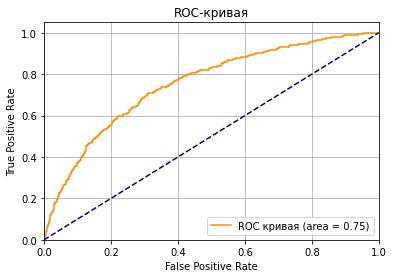

In [666]:
# получаем предказания
proba_valid = model_log_weighted.predict_proba(features_valid_scaled)
# сохраняем вероятности только для положительного исхода
proba_valid = proba_valid[:, 1]
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** Не смотря, что качество модели (F1 score) возрасло с 0.296 до 0.46, размер площали под кривой ROC остался неизменным.

Посмотрим, как изменится качество дерева решений и случайного леса.

In [667]:
model_tree_weighted = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_tree_weighted.fit(features_train_scaled, target_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [668]:
predictions_valid = model_tree_weighted.predict(features_valid_scaled)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_tree_weighted.predict_proba(features_valid.values)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.43271767810026385
AUC-ROC: 0.5


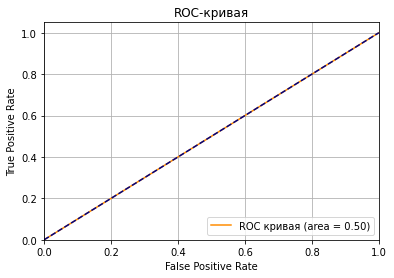

In [669]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [670]:
model_forest_weighted = RandomForestClassifier(random_state=42, class_weight='balanced')
model_forest_weighted.fit(features_train_scaled, target_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [671]:
predictions_valid = model_forest_weighted.predict(features_valid_scaled)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_forest_weighted.predict_proba(features_valid.values)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.5527638190954774
AUC-ROC: 0.40190220922677067


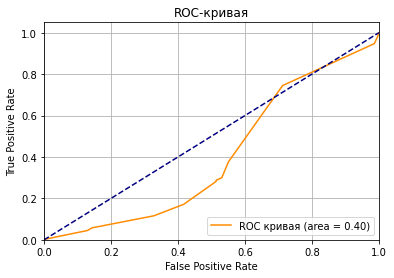

In [672]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** Для моделей случайного леса и дерева решений качество на валидационной выборке ухудшилось. Лучше рассмотреть иные варианты борьбы с дисбалансом.

### Увеличение выборки 

In [6]:
# заново разбить выборку на трейн и тест
# поскольку мы будем использовать GridSearchCV, нам не понадобится валидационная выборка

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=42)

Следующий подход – искусственное увеличение выборки. Меньше всего наблюдений в группе тех, кто ушел из банка. Этот класс мы будем искусственно увеличивать. Для этого разделим обучающую выборку по классам, скопируем несколько раз объекты меньшего класса, создадим новую обучающуюся выборку и перемешаем данные.

Попробуем увеличить выборку и обучить решающее дерево. Подберем наилучшие параметры для модели, обучим модель, посчитаем метрику F1 score и площадь под кривой AUC-ROC. 

Для этого напишем класс `Upsampling()`, в который будет искуственно увеличивать класс тех, кто ушел из банка (значение таргета – 1).

In [600]:
class Upsampling():
    def fit_resample(self, features, target, repeat):
        
        mask_ones = target == 1
        mask_zeros = ~mask_ones
    
        features_zeros, features_ones = features[mask_zeros], features[mask_ones]
        target_zeros, target_ones = target[mask_zeros], target[mask_ones]
        
        features_upsampled = pd.concat([features_zeros] + [features_ones.copy() for _ in range(repeat)])
        target_upsampled = pd.concat([target_zeros] + [target_ones.copy() for _ in range(repeat)])
        
        features_upsampled, target_upsampled = shuffle(
            features_upsampled, target_upsampled, random_state=42)
        
        return features_upsampled, target_upsampled

Далее подберем параметры для дерева решений. Будем использовать GridSearchCV. Мы используем пайплайн для того, чтобы избежать проблемы утечки данных. Благодаря пайплайну увеличивалась только та выборка, на которой модель подбирала параметры – валидационная выборка, которая использовалась для проверки, не увеличивалась.

In [601]:
%%time

pipe_tree = Pipeline([('upsampling', Upsampling()), 
                      ('tree_clf', DecisionTreeClassifier(random_state=42))])

params = {'tree_clf__max_depth': range(1,13,2),
          'tree_clf__min_samples_leaf': range(1,8),
          'tree_clf__min_samples_split': range(2,10,2)
         }

grid_tree = GridSearchCV(pipe_tree, params, cv=KFold(n_splits=5))
grid_tree.fit(features_train, target_train, upsampling__repeat=4)

CPU times: user 22.6 s, sys: 139 ms, total: 22.7 s
Wall time: 22.8 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('upsampling',
                                        <__main__.Upsampling object at 0x7f938c792790>),
                                       ('tree_clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tree_clf__max_depth': range(1, 13, 2),
                         'tree_clf__min_samples_leaf': range(1, 8),
                         'tree_clf__min_samples_split': range(2, 10, 2)})

In [674]:
predictions_test = grid_tree.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_tree.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5368790767686904
AUC-ROC: 0.7550065792019814


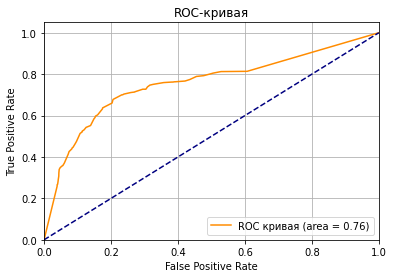

In [675]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Проблема дисбаланса классов была решена, но площадь по ROC-кривой значительно сократилась. Возможно, стоит рассмотреть другие техники для увеличения выборки. Например, Synthetic Minority Oversampling Technique (SMOTE), когда мы не просто копируем объекты из выборки, а генерируем их синтетически.

In [604]:
%%time

pipe_tree2 = Pipeline([('smote', SMOTE(random_state=42)), 
                      ('tree_clf', DecisionTreeClassifier(random_state=42))])

grid_tree2 = GridSearchCV(pipe_tree2, params, cv=KFold(n_splits=5))
grid_tree2.fit(features_train, target_train)

CPU times: user 30 s, sys: 159 ms, total: 30.2 s
Wall time: 30.2 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('tree_clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tree_clf__max_depth': range(1, 13, 2),
                         'tree_clf__min_samples_leaf': range(1, 8),
                         'tree_clf__min_samples_split': range(2, 10, 2)})

In [676]:
predictions_test = grid_tree2.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_tree2.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5340314136125655
AUC-ROC: 0.8073077518479818


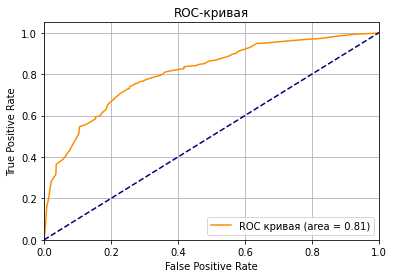

In [677]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Качество дерева решений, оцениваемое по площади под кривой ROC, явно улучшилось. Далее будем использовать технику SMOTE для увеличения выборки.

In [607]:
%%time

pipe_forest = Pipeline([('smote', SMOTE(random_state=42)), 
                      ('forest_clf', RandomForestClassifier(random_state=42))])

params = {'forest_clf__max_depth': range(10, 30,2),
          'forest_clf__n_estimators': range(30, 60, 5)}

grid_forest = GridSearchCV(pipe_forest, params, cv=KFold(n_splits=5))
grid_forest.fit(features_train, target_train)

CPU times: user 2min 8s, sys: 543 ms, total: 2min 9s
Wall time: 2min 9s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(10, 30, 2),
                         'forest_clf__n_estimators': range(30, 60, 5)})

In [678]:
predictions_test = grid_forest.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_forest.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5620991253644314
AUC-ROC: 0.8195700297999149


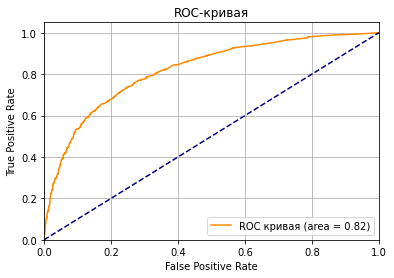

In [609]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Качество случайного после восполнения недостающего класса леса немного (на 0.01) ухудшилось, но зато дисбаланс в выборке был учтен. Рассмотрим линейный классификатор.

In [610]:
%%time

pipe_linear = Pipeline([('smote', SMOTE(random_state=42)),
                        ('scaler', StandardScaler()),
                        ('linear_clf', LogisticRegression())])

pipe_linear.fit(features_train, target_train)

CPU times: user 35.9 ms, sys: 23.3 ms, total: 59.2 ms
Wall time: 31.9 ms


Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('linear_clf', LogisticRegression())])

In [679]:
predictions_test = pipe_linear.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = pipe_linear.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.47588832487309646
AUC-ROC: 0.768598242966059


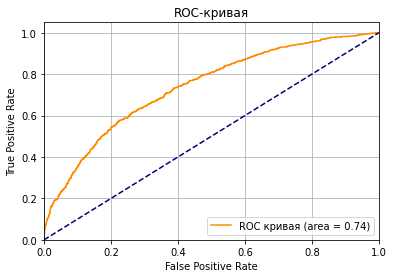

In [612]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Хотя площадь под ROC-кривой немного (на 0.01) сократилась, оценка F1 значительно возрасла.

**Вывод:** Оценка дерева решений F1 выросла с 0.45 до 0.53, площадь под ROC-кривой увеличилась с 0.66 до 0.81. Оценка F1 линейного классификатора также увеличилась с 0.296 до 0.48, а площадь под ROC-кривой немного сократилась с 0.75 до 0.74. Оценка случайного леса F-score изменилась с 0.55 до 0.563, площадь под ROC-кривой с 0.83 до 0.82.

Случайный лес по-прежнему остаётся лучшей моделью для решения поставленной задачи классификации с учетом дисбаланса классов.

### Уменьшение выборки

Альтернативный подход – удаление части наблюдений из наибольшего класса. В нашем случае наибольший класс – те, кто не ушел из банка. Разделим обучающую выборку по классам, случайным образом отбросим часть объектов из большего класса, создадим новую часть выборки и перемешаем данные.

In [613]:
class Downsampling():
    def fit_resample(self, features, target, fraction):
        
        mask_ones = target == 1
        mask_zeros = ~mask_ones
    
        features_zeros, features_ones = features[mask_zeros], features[mask_ones]
        target_zeros, target_ones = target[mask_zeros], target[mask_ones]
        
        features_downsampled = pd.concat(
            [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
        target_downsampled = pd.concat(
            [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
        
        features_downsampled, target_downsampled = shuffle(
            features_downsampled, target_downsampled, random_state=42)
        
        return features_downsampled, target_downsampled

Получим наилучшие параметры для модели случайного дерева, обучим и оценим модель: получим F1 score и площадь под кривой AUC-ROC. 

In [641]:
%%time

pipe_tree_down = Pipeline([('downsampling', Downsampling()), 
                      ('tree_clf', DecisionTreeClassifier(random_state=42))])

params = {'tree_clf__max_depth': range(1,13,2),
          'tree_clf__min_samples_leaf': range(1,8),
          'tree_clf__min_samples_split': range(2,10,2)
         }

grid_tree_down = GridSearchCV(pipe_tree_down, params, cv=KFold(n_splits=5))
grid_tree_down.fit(features_train, target_train, downsampling__fraction=0.4)

CPU times: user 12.6 s, sys: 51.6 ms, total: 12.7 s
Wall time: 12.7 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('downsampling',
                                        <__main__.Downsampling object at 0x7f9328a978b0>),
                                       ('tree_clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tree_clf__max_depth': range(1, 13, 2),
                         'tree_clf__min_samples_leaf': range(1, 8),
                         'tree_clf__min_samples_split': range(2, 10, 2)})

In [681]:
predictions_test = grid_tree_down.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_tree_down.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5790944661822247
AUC-ROC: 0.8279027826154263


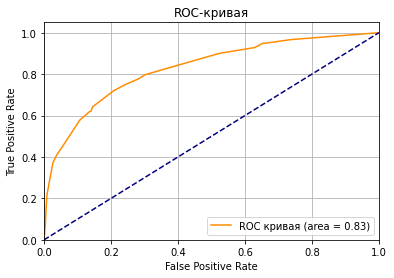

In [682]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Также есть более искусные техники для уменьшения выборки, например, с элементами рандомизации – Random Under Sampler, который уменьшает превалирующий класс, рандомно выбирая сэмплы так, чтобы итоговая пропорция выборок была 1:1 (`sampling_strategy=0.5`).

In [617]:
pipe_tree_down2 = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)), 
                      ('tree_clf', DecisionTreeClassifier(random_state=42))])

params = {'tree_clf__max_depth': range(1,13,2),
          'tree_clf__min_samples_leaf': range(1,8),
          'tree_clf__min_samples_split': range(2,10,2)
         }

grid_tree_down2 = GridSearchCV(pipe_tree_down2, params, cv=KFold(n_splits=5))
grid_tree_down2.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('RUS',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('tree_clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tree_clf__max_depth': range(1, 13, 2),
                         'tree_clf__min_samples_leaf': range(1, 8),
                         'tree_clf__min_samples_split': range(2, 10, 2)})

In [683]:
predictions_test = grid_tree_down2.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_tree_down2.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5081839438815278
AUC-ROC: 0.7929902473005921


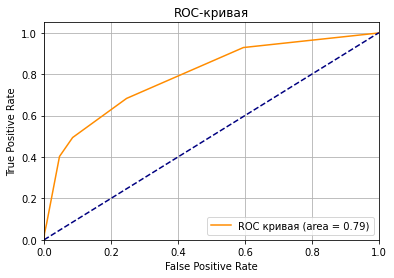

In [684]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Мы видим, что с использованием `RandomUnderSampler()` наша метрика качества ниже по сравнению с той, что удалось достичь с использованием нашего класса `Downsampling()`.

Сравним эти две техники на модёли случайного леса.

In [638]:
%%time

pipe_forest_down2 = Pipeline([('downsampling', Downsampling()), 
                      ('forest_clf', RandomForestClassifier(random_state=42))])

params = {'forest_clf__max_depth': range(1,13,2),
          'forest_clf__n_estimators': range(10, 30, 10)}

grid_forest_down2 = GridSearchCV(pipe_forest_down2, params, cv=KFold(n_splits=5))
grid_forest_down2.fit(features_train, target_train, downsampling__fraction=0.4)

CPU times: user 3.11 s, sys: 31.5 ms, total: 3.15 s
Wall time: 3.16 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('downsampling',
                                        <__main__.Downsampling object at 0x7f93480adb50>),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(1, 13, 2),
                         'forest_clf__n_estimators': range(10, 30, 10)})

In [686]:
predictions_test = grid_forest_down2.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_forest_down2.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5772759350741001
AUC-ROC: 0.8313936297844344


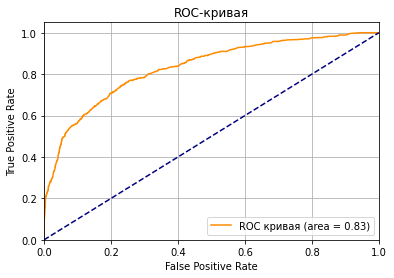

In [640]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [635]:
%%time

pipe_forest_down = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)), 
                      ('forest_clf', RandomForestClassifier(random_state=42))])

params = {'forest_clf__max_depth': range(1,13,2),
          'forest_clf__n_estimators': range(10, 30, 10)}

grid_forest_down = GridSearchCV(pipe_forest_down, params, cv=KFold(n_splits=5))
grid_forest_down.fit(features_train, target_train)

CPU times: user 3.39 s, sys: 48.7 ms, total: 3.43 s
Wall time: 3.46 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('RUS',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(1, 13, 2),
                         'forest_clf__n_estimators': range(10, 30, 10)})

In [685]:
predictions_test = grid_forest_down.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_forest_down.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5884802220680083
AUC-ROC: 0.8448169433801618


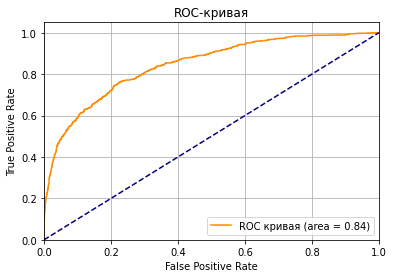

In [637]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Для случайного леса техника `RandomUnderSampler` показывает лучший результат, максимальный из всех полученных. Теперь рассмотрим линейный классификатор.

In [644]:
%%time

pipe_linear = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                        ('scaler', StandardScaler()),
                        ('linear_clf', LogisticRegression())])

pipe_linear.fit(features_train, target_train)

CPU times: user 31.8 ms, sys: 29.2 ms, total: 60.9 ms
Wall time: 27.6 ms


Pipeline(steps=[('RUS',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('scaler', StandardScaler()),
                ('linear_clf', LogisticRegression())])

In [687]:
predictions_test = pipe_linear.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = pipe_linear.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.47588832487309646
AUC-ROC: 0.768598242966059


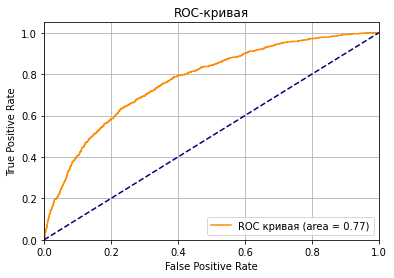

In [646]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** Дерево решений – было: F1 score 0.53, AUC-ROC 0.81; стало: F1 score 0.58, AUC-ROC 0.83. Линейный классификатор – было: F1 score 0.48, AUC-ROC 0.73 стало: F1 score 0.48, AUC-ROC 0.77. Небольшое увеличений показателей. Случайный лес – было: F1 score 0.563, AUC-ROC 0.82; стало: F1 score 0.59, AUC-ROC 0.84. По-прежнему результат лучше, чем у других моделей.

### Комбинация двух стратегий

На данном этапе лучше всего с задачей классификации и с учетом дисбаланса классов справляется модель случайного леса. Мы попробовали две стратегии для борьбы с дисбаланском – upsampling и downsampling, попробовали реализовать их как вручную, так и с помощью встроенных библиотек. В некоторых [статьях](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) предлагалось комбинировать upsampling и downsampling, то есть увеличивать недостающий класс и паралельно уменьшать тот класс, которого в избытке. Попробуем реализовать этот подход.

In [629]:
over = SMOTE(random_state=42)
under = RandomUnderSampler(random_state=42)
clf = RandomForestClassifier(random_state=42)
steps = [('over', over), ('under', under), ('forest_clf', clf)]
pipeline_combo = Pipeline(steps=steps)

In [630]:
params = {'forest_clf__max_depth': range(10,30,2),
          'forest_clf__n_estimators': range(30, 60, 5)}

grid_forest_combo = GridSearchCV(pipeline_combo, params, cv=KFold(n_splits=5))

grid_forest_combo.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('under',
                                        RandomUnderSampler(random_state=42)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(10, 30, 2),
                         'forest_clf__n_estimators': range(30, 60, 5)})

In [688]:
predictions_test = grid_forest_combo.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_forest_combo.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5602373887240357
AUC-ROC: 0.8166602809706258


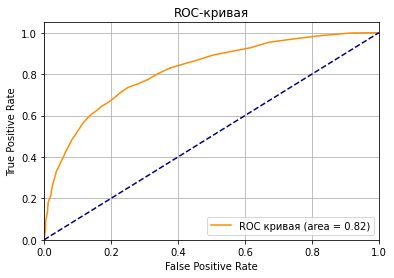

In [689]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** качество метрики F1 и площадь под кривой ROC ухудшилось после комбинирования двух подходов. 

Поскольку техника уменьшения выборки показала самый высокий результат, предлагается испольковать её.

## Тестирование модели

In [690]:
predictions_test = grid_forest_down.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_forest_down.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5884802220680083
AUC-ROC: 0.8448169433801618


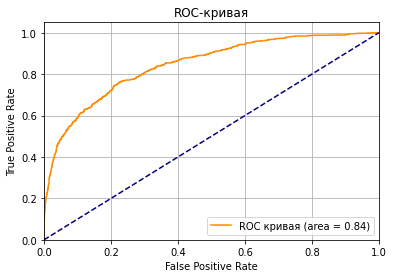

In [691]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Выводы:** Самые высокие показатели оценки F1 на тесте показал случайный лес. Предлагается использовать данную модель для решения поставленной задачи. Также предлагается испоьзовать технику балансировки классов "уменьшение выборки". Благодаря этому можно получить высокую оценку качества ROC-AUC (0.84) и высокий показатель F1, равный 0.59.

## Вывод

Мы построили предсказательную модель, которая определяет, уйдет ли клиент из банка или нет. Самая лучшая оценка на тестовой и валидационной выборе у случайного леса, поэтому предлагается использовать эту модель в работе. В исследовании мы последовательно изучили и подготовили данные. Определив, что в выборке есть дисбаланс классов, решили эту проблему, отдав предпочтение стратегии уменьшения выборки. В результате мы достигли значение F score = 0.59 на тестовой выборке. Площадь под кривой ROC составила 0.84, что также свидетельствует о хорошей прдесказательной способности модели. 